In [1]:
import time
import sys
import os
import dgl
import torch
project_path = os.path.abspath(os.path.join(os.getcwd(), '..', ''))
sys.path.append(project_path)

from modulus.launch.utils import load_checkpoint, save_checkpoint
from python.CustomMGNSimilarity import MeshGraphNet

In [12]:

def create_dummy_graph():
    # Create a graph with 9 nodes and 15 edges (randomly chosen)
    num_nodes = 400000
    num_edges = 2000000
    src = torch.randint(0, num_nodes, (num_edges,))
    dst = torch.randint(0, num_nodes, (num_edges,))

    graph = dgl.graph((src, dst))

    # Add node data: 9 nodes with 3 features in 'x' and 'y'
    graph.ndata['x'] = torch.randn(num_nodes, 9)  # 9 features per node
    graph.ndata['y'] = torch.randn(num_nodes, 3)  # 3 additional features per node

    # Add edge data: 15 edges with 3 features in 'x'
    graph.edata['x'] = torch.randn(num_edges, 3)  # 3 features per edge

    return graph

# Create the dummy graph
dummy_graph = create_dummy_graph()

In [13]:
model_test = MeshGraphNet(9,
            3,
            3,
            processor_size=10,
            hidden_dim_processor=64,
            hidden_dim_node_encoder=64,
            hidden_dim_edge_encoder=64,
            hidden_dim_node_decoder=64,
            do_concat_trick=True,
            num_processor_checkpoint_segments=0,)

In [14]:
def compute_dirichlet_energy(graph: dgl.DGLGraph) -> torch.Tensor:
    """
    Compute the Dirichlet energy for the graph's node features.
    
    The node features are stored in graph.ndata['x'].
    
    Parameters
    ----------
    graph : dgl.DGLGraph
        The graph containing node features `x` and edges.

    Returns
    -------
    torch.Tensor
        The computed Dirichlet energy (a scalar).
    """
    with graph.local_scope():
        # Node features
        node_features = graph.ndata['x']
        
        # Broadcast node features to edges
        graph.ndata['x'] = node_features
        graph.apply_edges(lambda edges: {
            'diff': edges.src['x'] - edges.dst['x']  # Compute differences between connected nodes
        })
        
        # Compute squared L2 norm for each edge
        graph.edata['squared_diff'] = torch.sum(graph.edata['diff'] ** 2, dim=-1)
        
        # Sum over all edges and normalize by the number of nodes
        dirichlet_energy = graph.edata['squared_diff'].sum() / graph.num_nodes()
    
    return dirichlet_energy



In [ ]:
# Create a dummy graph
dummy_graph = create_dummy_graph()

# Extract node and edge features
node_features = dummy_graph.ndata['x']
edge_features = dummy_graph.edata['x']

# Run the model
with torch.no_grad():
    output, dirichlet_energies = model_test(node_features, edge_features, dummy_graph)

print("Dirichlet Energies at each message passing step:", dirichlet_energies)


: 

: 

: 

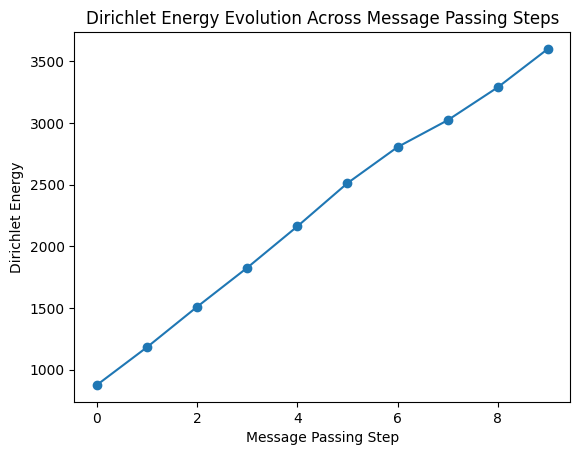

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(dirichlet_energies)), dirichlet_energies, marker='o')
plt.xlabel('Message Passing Step')
plt.ylabel('Dirichlet Energy')
plt.title('Dirichlet Energy Evolution Across Message Passing Steps')
plt.show()
